In [37]:
import cobra
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
# Load the model -- Elad recommends iML1515
coli_model = cobra.io.read_sbml_model("../models/iML1515.xml")

In [3]:
# Set up a medium without C or electron acceptors
my_medium = coli_model.medium.copy()
my_medium['EX_glc__D_e'] = 0 
my_medium['EX_o2_e'] = 0

In [4]:
# List of electron acceptors to test
e_acceptors = {
    'NO3': 'EX_no3_e',
    'O2': 'EX_o2_e',
    #'fumarate': 'EX_fum_e',
    'TMAO': 'EX_tmao_e',
    'DMSO': 'EX_dmso_e',
    'fermentation': None,
}

# Get the C exchanges from the model
c_exchanges = {}
for e in coli_model.exchanges:
    for m in e.metabolites.keys():
        if m.elements.get('C', 0) > 0:
            c_exchanges[e.id] = m.name

# Manual list of C sources to try
c_exchanges2test = [
    dict(name='glucose', type='sugar', ex_id='EX_glc__D_e'),
    dict(name='acetate', type='organic acid', ex_id='EX_ac_e'),
    dict(name='glycerol', type='sugar alcohol', ex_id='EX_glyc_e'),
    dict(name='succinate', type='organic acid', ex_id='EX_succ_e'),
    dict(name='fumarate', type='organic acid', ex_id='EX_fum_e'),
    dict(name='pyruvate', type='organic acid', ex_id='EX_pyr_e'),
    dict(name='lactate', type='organic acid', ex_id='EX_lac__D_e'),
    dict(name='ethanol', type='alcohol', ex_id='EX_etoh_e'),
    dict(name='alanine', type='amino acid', ex_id='EX_ala__L_e'),
    dict(name='glycine', type='amino acid', ex_id='EX_gly_e'),
    dict(name='serine', type='amino acid', ex_id='EX_ser__L_e'),
    dict(name='threonine', type='amino acid', ex_id='EX_thr__L_e'),
    dict(name='valine', type='amino acid', ex_id='EX_val__L_e'),
    dict(name='leucine', type='amino acid', ex_id='EX_leu__L_e'),
    dict(name='isoleucine', type='amino acid', ex_id='EX_ile__L_e'),
    dict(name='cytosine', type='nucleobase', ex_id='EX_cytd_e'),
    dict(name='uracil', type='nucleobase', ex_id='EX_ura_e'),
    dict(name='adenine', type='nucleobase', ex_id='EX_adn_e'),
    dict(name='guanine', type='nucleobase', ex_id='EX_gua_e'),
    dict(name='thymine', type='nucleobase', ex_id='EX_thym_e'),
    dict(name='uridine', type='nucleoside', ex_id='EX_uri_e'),
    dict(name='sucrose', type='sugar', ex_id='EX_sucr_e'),
    dict(name='trehalose', type='sugar', ex_id='EX_tre_e'),
    dict(name='maltose', type='sugar', ex_id='EX_malt_e'),
    dict(name='gluconate', type='sugar acid', ex_id='EX_gal_e'),
    dict(name='glucuronate', type='sugar acid', ex_id='EX_glcur_e'),
    dict(name='galacturonate', type='sugar acid', ex_id='EX_galur_e'),
    dict(name='glucarate', type='sugar acid', ex_id='EX_glcr_e'),
    dict(name='rhamnose', type='sugar', ex_id='EX_rmn_e'),
    dict(name='arabinose', type='sugar', ex_id='EX_arab__L_e'),
    dict(name='xylose', type='sugar', ex_id='EX_xyl__D_e'),
    dict(name='fucose', type='sugar', ex_id='EX_fuc__L_e'),
    dict(name='mannose', type='sugar', ex_id='EX_man_e'),
    dict(name='fructose', type='sugar', ex_id='EX_fru_e'),
    dict(name='sorbitol', type='sugar alcohol', ex_id='EX_sbt__D_e'),
    dict(name='hexadecenoate', type='fatty acid', ex_id='EX_hdcea_e'),
    dict(name='tetradecenoate', type='fatty acid', ex_id='EX_ttdcea_e'),
    dict(name='tetradecanoate', type='fatty acid', ex_id='EX_ttdca_e'),
    dict(name='octadecanoate', type='fatty acid', ex_id='EX_ocdca_e'),
    dict(name='octadecenoate', type='fatty acid', ex_id='EX_ocdcea_e'),
    dict(name='hexanoate', type='fatty acid', ex_id='EX_hxa_e'),
    dict(name='decanoate', type='fatty acid', ex_id='EX_dca_e'),
    dict(name='octanoate', type='fatty acid', ex_id='EX_octa_e'),
    dict(name='hexadecanoate', type='fatty acid', ex_id='EX_hdca_e'),
    dict(name='dodecanoate', type='fatty acid', ex_id='EX_ddca_e'),
    dict(name='3-hydroxypropanoate', type='organic acid', ex_id='EX_3hpp_e'),
]

# Check that all C sources are in the model
for c in c_exchanges2test:
    if c['ex_id'] not in c_exchanges:
        print(c['name'], 'not found')

In [5]:
# Run FBA for all combinations of C and e- acceptors
growth_data = []
for i, (e, e_ex) in enumerate(e_acceptors.items()):
    for j, c_ex in enumerate(c_exchanges2test):
        tmp_medium = my_medium.copy()
        tmp_medium[c_ex['ex_id']] = 10

        # None signals fermentation (no e- acceptor)
        if e_ex is not None:
            tmp_medium[e_ex] = 1000

        tmp_model = coli_model.copy()
        tmp_model.medium = tmp_medium

        # Calculate the model's growth rate and save
        mu = tmp_model.slim_optimize()
        growth_data.append(dict(
            e_acceptor=e,
            c_source=c_ex['name'],
            c_source_type=c_ex['type'],
            growth_rate_hr=mu,
        ))

In [41]:
# Convert to a dataframe
long_growth_df = pd.DataFrame(growth_data)

# Binarize growth 
long_growth_df['grows'] = long_growth_df.growth_rate_hr > 0.01
growth_mat_df = long_growth_df.pivot_table(
    index='c_source_type,c_source'.split(','), 
    columns='e_acceptor', values='growth_rate_hr').reset_index()
#growth_mat_df = growth_mat_df.fillna(0)

# Drop C sources with no growth at all
no_grow = (growth_mat_df == 0).all(axis=1)
growth_mat_df = growth_mat_df.drop(no_grow.index[no_grow]).sort_values('c_source_type').set_index(
    'c_source_type,c_source'.split(','))

binary_growth_mat_df = growth_mat_df.fillna(0) > 0.01



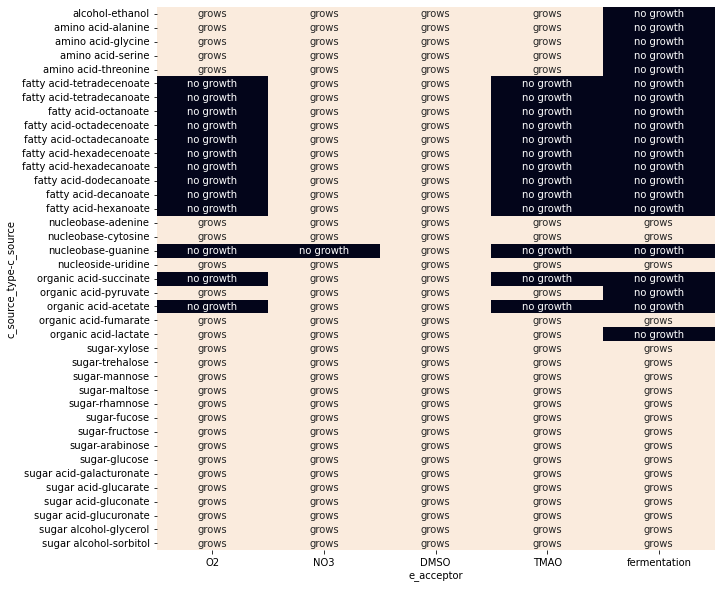

In [52]:
cols = 'O2,NO3,DMSO,TMAO,fermentation'.split(',')
cmap = sns.color_palette('cividis', as_cmap=True)
cmap.set_bad('white')

plt.figure(figsize=(10, 10))
annot = binary_growth_mat_df.replace({True: 'grows', False: 'no growth'})
sns.heatmap(binary_growth_mat_df, annot=annot, cbar=False, fmt='',
            xticklabels=cols)
plt.savefig('../output/iML1515_growth_mat.png', dpi=300, bbox_inches='tight', facecolor='white')

In [48]:
annot

e_acceptor                     DMSO    NO3    O2   TMAO  fermentation
c_source_type c_source                                               
alcohol       ethanol          True   True  True   True         False
amino acid    alanine          True   True  True   True         False
              glycine          True   True  True   True         False
              serine           True   True  True   True         False
              threonine        True   True  True   True         False
fatty acid    tetradecenoate  False   True  True  False         False
              tetradecanoate  False   True  True  False         False
              octanoate       False   True  True  False         False
              octadecenoate   False   True  True  False         False
              octadecanoate   False   True  True  False         False
              hexadecenoate   False   True  True  False         False
              hexadecanoate   False   True  True  False         False
              dodecanoate     False   True  True  False         False
              decanoate       False   True  True  False         False
              hexanoate       False   True  True  False         False
nucleobase    adenine          True   True  True   True          True
              cytosine         True   True  True   True          True
              guanine         False  False  True  False         False
nucleoside    uridine          True   True  True   True          True
organic acid  succinate       False   True  True  False         False
              pyruvate         True   True  True   True         False
              acetate         False   True  True  False         False
              fumarate         True   True  True   True          True
              lactate          True   True  True   True         False
sugar         xylose           True   True  True   True          True
              trehalose        True   True  True   True          True
              mannose          True   True  True   True          True
              maltose          True   True  True   True          True
              rhamnose         True   True  True   True          True
              fucose           True   True  True   True          True
              fructose         True   True  True   True          True
              arabinose        True   True  True   True          True
              glucose          True   True  True   True          True
sugar acid    galacturonate    True   True  True   True          True
              glucarate        True   True  True   True          True
              gluconate        True   True  True   True          True
              glucuronate      True   True  True   True          True
sugar alcohol glycerol         True   True  True   True          True
              sorbitol         True   True  True   True          True